In [1]:
import os
import pickle
import numpy as np
from bayes_opt import BayesianOptimization
from utils.TSDataset import data_load
from utils.cnnlstm_eval import cnn_lstm_model_eval
from utils.models import *
from utils.model_bo import cnn_lstm_model_bo

In [2]:
project_dir = os.path.dirname(os.path.abspath('__file__'))

if not os.path.exists(os.path.join(project_dir, 'output')):
    os.makedirs(os.path.join(project_dir, 'output'))

data_path = os.path.join(project_dir, 'data', 'processed', 'BTC-USD-sample.csv')
output_dir = os.path.join(project_dir, 'output')

# Load data
data, x_scaler, y_scaler = data_load(data_path, x_scaler='minmax', y_scaler='minmax')

# Configuration
data_frame       = data
scaler           = y_scaler
feature_cols     = ['x1','x2','x3','x4','x5']
target_col       = 'y'
seq2seq          = True

strides          = 1

full = data[feature_cols + [target_col]].to_numpy(dtype=np.float32)
np.save('full.npy', full)

npy_path        = 'full.npy'
targ_idx = 0
feat_idx = list(range(1,6))
print(len(data_frame))

14400


In [ ]:
# One Step Forecasting
forecast_horizon = 30

# Step 1: Define hyperparameter bounds
pbounds = {
    'filters':       (16, 256),
    'kernel_size':   (2, 8), 
    'lstm_units':    (16, 256),
    'learning_rate': (1e-5, 1e-1),
    'epochs':        (1, 2),
    'window_size':   (50, 3000),
    'batch_size':    (16, 128),
}

# Step 2: Define the target function
def hpo_target(filters, kernel_size, lstm_units, learning_rate,
               epochs, window_size, batch_size):
    return cnn_lstm_model_bo(
        df=data_frame, npy_path=npy_path, verbose=True,
        feat_idx = feat_idx,
        targ_idx = targ_idx,
        dates_npy_path = None,
        filters=int(filters),
        kernel_size=int(kernel_size),
        lstm_units=int(lstm_units),
        learning_rate=learning_rate,
        epochs=int(epochs),
        window_size=int(window_size),
        batch_size=int(batch_size),
        forecast_horizon=forecast_horizon
    )

# ── 4) Run Bayesian Optimization ──
optimizer = BayesianOptimization(f=hpo_target, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=10, n_iter = 20)

# ── 5) Pull out the best set (casting ints where needed) ──
best = optimizer.max['params']
best = {k: int(v) if k in pbounds else v for k, v in best.items()}
print("🔍 Best hyperparameters:", best)

|   iter    |  target   | batch_... |  epochs   |  filters  | kernel... | learni... | lstm_u... | window... |
-------------------------------------------------------------------------------------------------------------


Epoch 01 | val_loss: 0.0020 | val_time:  27.94s
| 1         | -0.002034 | 57.95     | 1.951     | 191.7     | 5.592     | 0.01561   | 53.44     | 221.3     |


Epoch 1/1:  83%|████████▎ | 69/83 [484837:35:22<00:28,  2.06s/it]

In [4]:
forecast_horizon = 30
# Example best

#best = {'filters': 90, 'kernel_size': 5, 'lstm_units': 149, 'learning_rate': 0.003124, 'epochs': 20, 'window_size': 569, 'batch_size': 159}
best = {'filters': 114, 'kernel_size': 5, 'lstm_units': 77, 'learning_rate': 0.007854, 'epochs': 20, 'window_size': 539, 'batch_size': 253}
mse, mae, y_pred, y_true, history = cnn_lstm_model_eval(df = data_frame,
                                               npy_path = npy_path,
                                               data_scaler = scaler,
                                               feat_idx = feat_idx,
                                               targ_idx = targ_idx,
                                               filters = best['filters'],
                                               window_size = best['window_size'],
                                               kernel_size = best['kernel_size'],
                                               lstm_units = best['lstm_units'],
                                               learning_rate = best['learning_rate'],
                                               epochs = best['epochs'],
                                               forecast_horizon = forecast_horizon,
                                               batch_size = best['batch_size'],
                                               num_workers = 4)
print(y_true.shape)
print(y_pred.shape)

print(mse)
print(mae)

Starting training...
Epoch 01/20 — train_loss: 4.5167e-03 — time: 45.79s
Epoch 02/20 — train_loss: 3.1842e-03 — time: 47.12s
Epoch 03/20 — train_loss: 3.0818e-03 — time: 47.48s
Epoch 04/20 — train_loss: 2.9228e-03 — time: 48.76s
Epoch 05/20 — train_loss: 2.8192e-03 — time: 49.51s
Epoch 06/20 — train_loss: 2.7737e-03 — time: 48.38s
Epoch 07/20 — train_loss: 2.6548e-03 — time: 51.51s
Epoch 08/20 — train_loss: 2.6088e-03 — time: 52.93s
Epoch 09/20 — train_loss: 2.8152e-03 — time: 53.54s
Epoch 10/20 — train_loss: 2.6211e-03 — time: 53.18s
Epoch 11/20 — train_loss: 2.5677e-03 — time: 52.43s
Epoch 12/20 — train_loss: 2.5103e-03 — time: 54.37s
Epoch 13/20 — train_loss: 2.4719e-03 — time: 58.32s
Epoch 14/20 — train_loss: 2.4677e-03 — time: 68.07s
Epoch 15/20 — train_loss: 2.4402e-03 — time: 64.55s
Epoch 16/20 — train_loss: 2.3590e-03 — time: 62.82s
Epoch 17/20 — train_loss: 2.4688e-03 — time: 61.95s
Epoch 18/20 — train_loss: 2.3208e-03 — time: 64.64s
Epoch 19/20 — train_loss: 2.2180e-03 — time

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ------------------------------------------------------------------
# 0) Sanity-check & reshape
# ------------------------------------------------------------------
assert y_true.shape == y_pred.shape, "Shapes must match (N, W, H)"
N, W, H = y_true.shape

# flatten the forecast horizon last for some plots → (N*W, H)
yt_2d = y_true.reshape(-1, H)
yp_2d = y_pred.reshape(-1, H)
tag = "CNN-LSTM_30step"              # prefix for every file

# ------------------------------------------------------------
# 0) reshape & sanity-check
# ------------------------------------------------------------
assert y_true.shape == y_pred.shape, "Shapes must match (N, W, H)"
N, W, H = y_true.shape
yt_2d = y_true.reshape(-1, H)        # (N*W , H)
yp_2d = y_pred.reshape(-1, H)

# ------------------------------------------------------------
# 1) Horizon-wise MAE / RMSE
# ------------------------------------------------------------
mae_h  = [mean_absolute_error (yt_2d[:, h], yp_2d[:, h]) for h in range(H)]
rmse_h = [np.sqrt(mean_squared_error(yt_2d[:, h], yp_2d[:, h])) for h in range(H)]

plt.figure(figsize=(7, 4))
plt.plot(range(1, H+1), mae_h,  "o-", lw=2, label="MAE",  color='blue')
plt.plot(range(1, H+1), rmse_h, "x--", lw=2, label="RMSE", color='red')
plt.xlabel("Forecast step $h$")
plt.ylabel("Error")
plt.title("Error vs. forecast horizon")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"{tag}_error_curve.png"), dpi=300)
plt.close()

# ------------------------------------------------------------
# 2) Unity-scatter (first 6 & last 3 horizons)
# ------------------------------------------------------------
front  = list(range(min(6, H)))
back   = list(range(max(0, H-3), H))
horizons = front + [h for h in back if h not in front]
n_plots  = len(horizons)
n_cols   = 3
n_rows   = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(4*n_cols, 3.5*n_rows),
                         squeeze=False)

for i, h in enumerate(horizons):
    ax = axes[i // n_cols, i % n_cols]
    ax.scatter(yt_2d[:, h], yp_2d[:, h], s=4, alpha=0.20)
    lims = [yt_2d[:, h].min(), yt_2d[:, h].max()]
    ax.plot(lims, lims, 'r--', lw=1)
    ax.set_title(f"$h={h+1}$")
    ax.set_xlabel("True"); ax.set_ylabel("Pred"); ax.grid(True)

# delete unused axes
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

fig.suptitle("Unity-scatter (first 6 & last 3 horizons)", y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"{tag}_unity_scatter.png"), dpi=300)
plt.close()

# ------------------------------------------------------------
# 3) Heat-map of mean signed error  (W × H)
# ------------------------------------------------------------
err_wh = np.mean((y_pred - y_true).reshape(N, W, H), axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(err_wh, cmap="RdBu_r", center=0, cbar_kws=dict(label="Mean error"))
plt.xlabel("Forecast step $h$"); plt.ylabel("Window position $w$")
plt.title("Mean signed error per $(w,h)$")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"{tag}_error_heatmap.png"), dpi=300)
plt.close()

# ------------------------------------------------------------
# 4) Per-sample horizon traces  (pick three)
# ------------------------------------------------------------
samples = [0, 50, 200]
fig, axes = plt.subplots(len(samples), 1, figsize=(9, 3*len(samples)), sharex=True)

for ax, idx in zip(axes, samples):
    ax.plot(range(1, H+1), y_true[idx, -1, :], "o-", label="True final-row")
    ax.plot(range(1, H+1), y_pred[idx, -1, :], "x--", label="Pred final-row")
    ax.set_ylabel("Value"); ax.grid(True); ax.set_title(f"Sample {idx}")
axes[-1].set_xlabel("Forecast step $h$")
axes[0].legend()
plt.suptitle("Final-row horizon trace for selected samples", y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"{tag}_sample_traces.png"), dpi=300)
plt.close()

# ------------------------------------------------------------
# 5) Relative-error histogram
# ------------------------------------------------------------
rel_err = (yp_2d - yt_2d) / np.clip(yt_2d, 1e-8, None)
plt.figure(figsize=(6,4))
plt.hist(rel_err.ravel(), bins=60, edgecolor='k', alpha=0.85)
plt.title("Relative error distribution")
plt.xlabel("$(\hat{y}-y)/y$")
plt.ylabel("Count"); plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"{tag}_rel_err_hist.png"), dpi=300)
plt.close()

print(f"✓ Saved five figures to “{output_dir}/”")

✓ Saved five figures to “/Users/jeddyxie/CNN-LSTM/CNN-LSTM/output/”


In [ ]:
# One Step Forecasting
forecast_horizon = 30

# Step 1: Define hyperparameter bounds
pbounds = {
    'filters':       (16, 256),
    'kernel_size':   (2, 8), 
    'lstm_units':    (16, 256),
    'learning_rate': (1e-5, 1e-1),
    'epochs':        (1, 2),
    'window_size':   (50, 3000),
    'batch_size':    (16, 128),
}

# Step 2: Define the target function
def hpo_target(filters, kernel_size, lstm_units, learning_rate,
               epochs, window_size, batch_size):
    return cnn_lstm_model_bo(
        df=data_frame, npy_path=npy_path, verbose=True,
        feat_idx = feat_idx,
        targ_idx = targ_idx,
        dates_npy_path = None,
        filters=int(filters),
        kernel_size=int(kernel_size),
        lstm_units=int(lstm_units),
        learning_rate=learning_rate,
        epochs=int(epochs),
        window_size=int(window_size),
        batch_size=int(batch_size),
        forecast_horizon=forecast_horizon
    )

# ── 4) Run Bayesian Optimization ──
optimizer = BayesianOptimization(f=hpo_target, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=10, n_iter = 20)

# ── 5) Pull out the best set (casting ints where needed) ──
best = optimizer.max['params']
best = {k: int(v) if k in pbounds else v for k, v in best.items()}
print("🔍 Best hyperparameters:", best)

|   iter    |  target   | batch_... |  epochs   |  filters  | kernel... | learni... | lstm_u... | window... |
-------------------------------------------------------------------------------------------------------------


Epoch 01 | val_loss: 0.0020 | val_time:  27.94s
| 1         | -0.002034 | 57.95     | 1.951     | 191.7     | 5.592     | 0.01561   | 53.44     | 221.3     |


Epoch 1/1:  83%|████████▎ | 69/83 [484837:35:22<00:28,  2.06s/it]

In [ ]:
# One Step Forecasting
forecast_horizon = 30

# Step 1: Define hyperparameter bounds
pbounds = {
    'filters':       (16, 256),
    'kernel_size':   (2, 8), 
    'lstm_units':    (16, 256),
    'learning_rate': (1e-5, 1e-1),
    'epochs':        (1, 2),
    'window_size':   (50, 3000),
    'batch_size':    (16, 128),
}

# Step 2: Define the target function
def hpo_target(filters, kernel_size, lstm_units, learning_rate,
               epochs, window_size, batch_size):
    return cnn_lstm_model_bo(
        df=data_frame, npy_path=npy_path, verbose=True,
        feat_idx = feat_idx,
        targ_idx = targ_idx,
        dates_npy_path = None,
        filters=int(filters),
        kernel_size=int(kernel_size),
        lstm_units=int(lstm_units),
        learning_rate=learning_rate,
        epochs=int(epochs),
        window_size=int(window_size),
        batch_size=int(batch_size),
        forecast_horizon=forecast_horizon
    )

# ── 4) Run Bayesian Optimization ──
optimizer = BayesianOptimization(f=hpo_target, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=10, n_iter = 20)

# ── 5) Pull out the best set (casting ints where needed) ──
best = optimizer.max['params']
best = {k: int(v) if k in pbounds else v for k, v in best.items()}
print("🔍 Best hyperparameters:", best)

|   iter    |  target   | batch_... |  epochs   |  filters  | kernel... | learni... | lstm_u... | window... |
-------------------------------------------------------------------------------------------------------------


Epoch 01 | val_loss: 0.0020 | val_time:  27.94s
| 1         | -0.002034 | 57.95     | 1.951     | 191.7     | 5.592     | 0.01561   | 53.44     | 221.3     |


Epoch 1/1:  83%|████████▎ | 69/83 [484837:35:22<00:28,  2.06s/it]

In [ ]:
# One Step Forecasting
forecast_horizon = 30

# Step 1: Define hyperparameter bounds
pbounds = {
    'filters':       (16, 256),
    'kernel_size':   (2, 8), 
    'lstm_units':    (16, 256),
    'learning_rate': (1e-5, 1e-1),
    'epochs':        (1, 2),
    'window_size':   (50, 3000),
    'batch_size':    (16, 128),
}

# Step 2: Define the target function
def hpo_target(filters, kernel_size, lstm_units, learning_rate,
               epochs, window_size, batch_size):
    return cnn_lstm_model_bo(
        df=data_frame, npy_path=npy_path, verbose=True,
        feat_idx = feat_idx,
        targ_idx = targ_idx,
        dates_npy_path = None,
        filters=int(filters),
        kernel_size=int(kernel_size),
        lstm_units=int(lstm_units),
        learning_rate=learning_rate,
        epochs=int(epochs),
        window_size=int(window_size),
        batch_size=int(batch_size),
        forecast_horizon=forecast_horizon
    )

# ── 4) Run Bayesian Optimization ──
optimizer = BayesianOptimization(f=hpo_target, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=10, n_iter = 20)

# ── 5) Pull out the best set (casting ints where needed) ──
best = optimizer.max['params']
best = {k: int(v) if k in pbounds else v for k, v in best.items()}
print("🔍 Best hyperparameters:", best)

|   iter    |  target   | batch_... |  epochs   |  filters  | kernel... | learni... | lstm_u... | window... |
-------------------------------------------------------------------------------------------------------------


Epoch 01 | val_loss: 0.0020 | val_time:  27.94s
| 1         | -0.002034 | 57.95     | 1.951     | 191.7     | 5.592     | 0.01561   | 53.44     | 221.3     |


Epoch 1/1:  83%|████████▎ | 69/83 [484837:35:22<00:28,  2.06s/it]

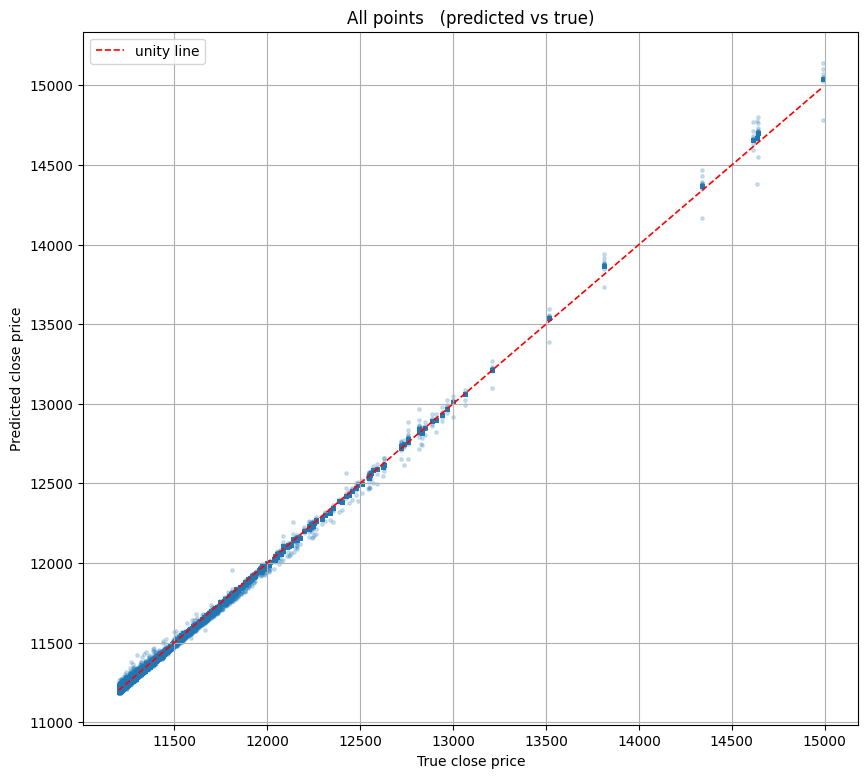

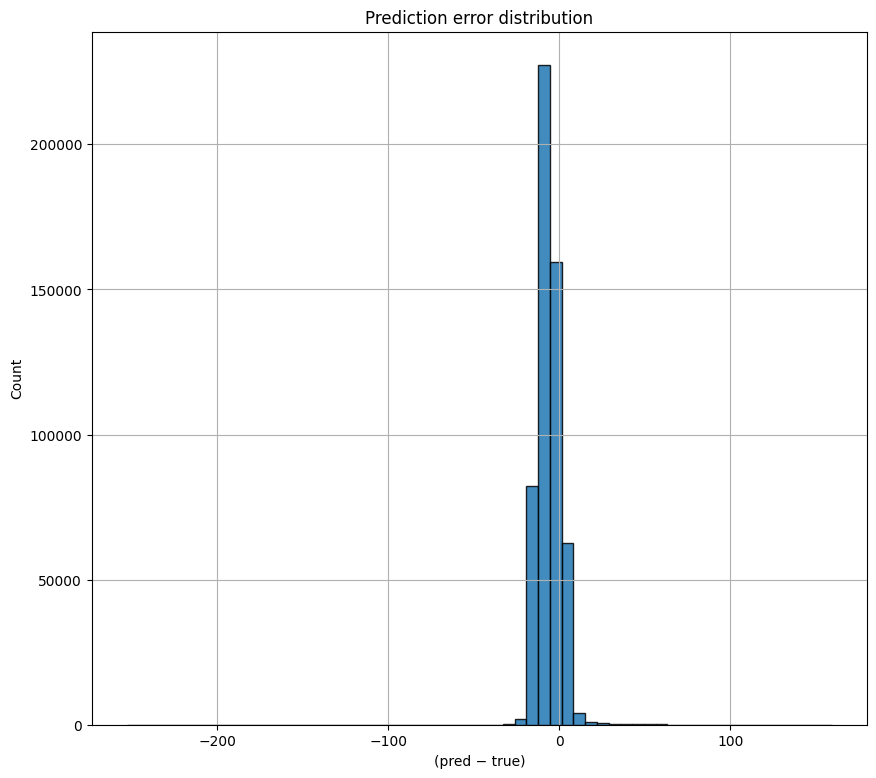

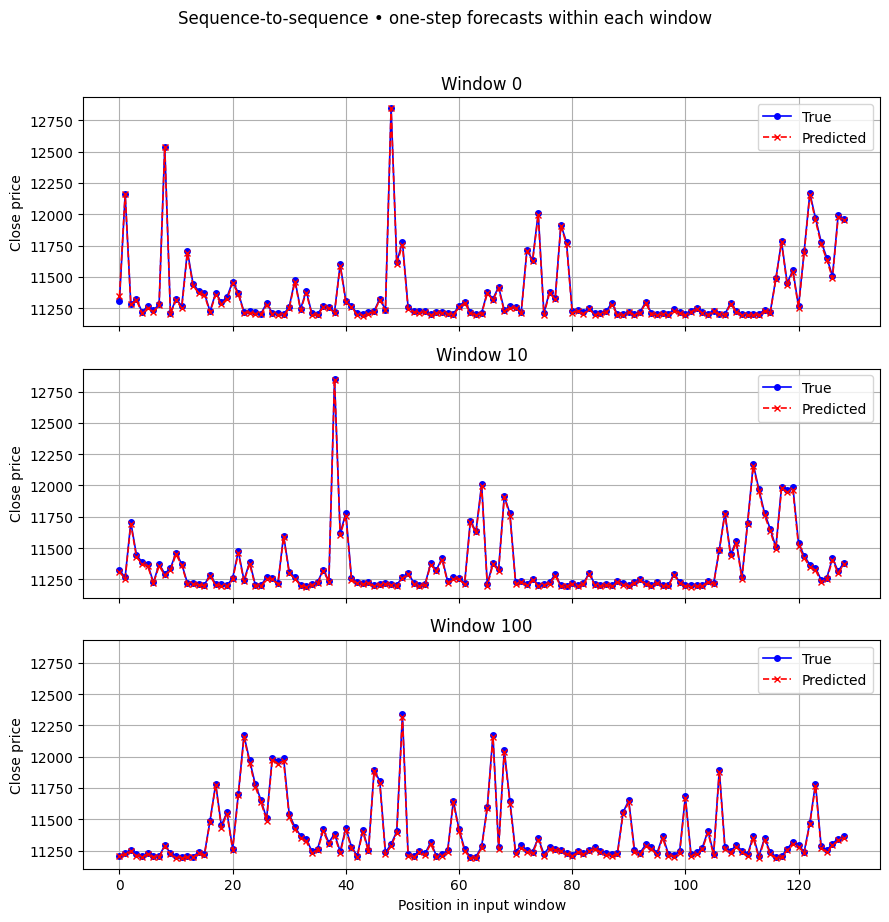

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Set a consistent figure width
FIG_WIDTH = 9

# ------------------------------------------------------------------
# 0) Sanity-check and reshape
# ------------------------------------------------------------------
assert y_true.shape == y_pred.shape, "Shapes must match"
assert y_true.ndim == 3 and y_true.shape[-1] == 1, "Expect (N, W, 1)"

y_true_2d = y_true.squeeze(-1)        # (N, W)
y_pred_2d = y_pred.squeeze(-1)        # (N, W)

# ------------------------------------------------------------------
# 1) Scatter plot: all points
# ------------------------------------------------------------------
yt_flat = y_true_2d.ravel()
yp_flat = y_pred_2d.ravel()

fig_scatter = plt.figure(figsize=(FIG_WIDTH+1, FIG_WIDTH))
plt.scatter(yt_flat, yp_flat, alpha=0.20, s=6)
lims = [yt_flat.min(), yt_flat.max()]
plt.plot(lims, lims, "r--", lw=1.2, label="unity line")
plt.xlabel("True close price")
plt.ylabel("Predicted close price")
plt.title("All points   (predicted vs true)")
plt.legend(); plt.grid(True)

# ------------------------------------------------------------------
# 2) Error histogram
# ------------------------------------------------------------------
errors = yp_flat - yt_flat
fig_hist = plt.figure(figsize=(FIG_WIDTH+1, FIG_WIDTH))
plt.hist(errors, bins=60, edgecolor="k", alpha=0.85)
plt.title("Prediction error distribution")
plt.xlabel("(pred − true)")
plt.ylabel("Count")
plt.grid(True)

# ------------------------------------------------------------------
# 3) Window-level traces for three samples
# ------------------------------------------------------------------
sample_idx = [0, 10, 100]      # change as you like
W = y_true_2d.shape[1]

fig, axes = plt.subplots(
    nrows=len(sample_idx), ncols=1,
    figsize=(FIG_WIDTH, 3 * len(sample_idx)), sharex=True, sharey=True
)

for ax, idx in zip(axes, sample_idx):
    ax.plot(range(W), y_true_2d[idx], "o-", ms=4, lw=1.2,
            label="True", color="blue")
    ax.plot(range(W), y_pred_2d[idx], "x--", ms=4, lw=1.2,
            label="Predicted", color="red")
    ax.set_title(f"Window {idx}")
    ax.set_ylabel("Close price")
    ax.legend(); ax.grid(True)

axes[-1].set_xlabel("Position in input window")
fig.suptitle("Sequence-to-sequence • one-step forecasts within each window",
             y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
forecast_horizon = 60
# Example best

#best = {'filters': 162, 'kernel_size': 3, 'lstm_units': 244, 'learning_rate': 0.00153, 'epochs': 40, 'window_size': 2899, 'batch_size': 82}
best = {'filters': 100, 'kernel_size': 3, 'lstm_units': 70, 'learning_rate': 0.00153, 'epochs': 40, 'window_size': 129, 'batch_size': 64}
mse, mae, y_pred, y_true, history = cnn_lstm_model_eval(df = data_frame,
                                               npy_path = npy_path,
                                               data_scaler = scaler,
                                               feat_idx = feat_idx,
                                               targ_idx = targ_idx,
                                               filters = best['filters'],
                                               window_size = best['window_size'],
                                               kernel_size = best['kernel_size'],
                                               lstm_units = best['lstm_units'],
                                               learning_rate = best['learning_rate'],
                                               epochs = best['epochs'],
                                               forecast_horizon = forecast_horizon,
                                               batch_size = best['batch_size'],
                                               num_workers = 4)

|   iter    |  target   | batch_... |  epochs   |  filters  | kernel... | learni... | lstm_u... | window... |
-------------------------------------------------------------------------------------------------------------


KeyboardInterrupt: 